# L-systems

F. Estrada - CSC D18 - Computer Graphics, Fall 2019

Modified to Juptyer by Mustafa Quraish, 2019

References: 
- [The Algorithmic Beauty of Plants](http://algorithmicbotany.org/papers/abop/abop.pdf)
- [StructureSynth examples of trees and plants](https://sites.google.com/site/workofap/structure-synth/other-structure-synth-example)

---

*Note: This notebook assumes you already have all the files with **3D** transformations in the same folder. If you don't, make sure you download them from the course site. The files from previous weeks will **not** work here*.

---

## What is an L-system?

An L-system or *Lindenmayer system* is a type of formal grammar (Think of CFGs from B36!). It consists of an alphabet of symbols that can be used to make strings, a collection of production rules that expand each symbol into some larger string of symbols. (Source: [Wiki](https://en.wikipedia.org/wiki/L-system))

---

The following function implements a simple L-system. It returns 

- `Tree`: An array that contains the structure of the system
- `Tranforms`: An array that contains the transformation matrices for each part of the tree

Note: Trees are hierarchical structures, so the transforms are obtained hierarchically in
this script.

However, notice that we return the ***final*** transform matrix for each piece (this is for convenience, so the code actually rendering the tree doesn't have to deal with compositing the hierarchical transforms).

---

We will now define a function that implements a simple L-system. Here, we will define our L-system to consist of the following symbols:

- $a$ : A tree / plant segment (cylinder of given length)
- $b$ : A tree / plant segment (cylinder of given length)
- $c$ : A leaf
- $d$ : A flower

*While $a$ and $b$ both represent the same thing, they are not actually the same. You will see this in a moment.*

Now, when we start, we will define the plant to contain a single symbol: 

"$a$"

The stem of the plant. Then, for a pre-defined number of rounds (the `depth` parameter), we take  we repeat the following process:

Replace each symbol in the current tree by choosing randomly from the following rules:

$$ a \rightarrow ab \text{ with probability } P_{a, ab} $$
$$ a \rightarrow ac \text{ with probability } P_{a, ac} $$
$$ a \rightarrow ad \text{ with probability } P_{a, ad} $$
$$ b \rightarrow a \text{ with probability } P_{b, a} $$
$$ b \rightarrow c \text{ with probability } P_{b, c} $$
$$ b \rightarrow d \text{ with probability } P_{b, d} $$

*Note that $c$ and $d$ are terminal symbols; they don't get expanded.*

For now, we will say that these are all the possible transitions. These probabilities are going to be passed in to the function in an array as the parameter `Probability_vector`.

For example, if:

```matlab
Probability_vector = [0.6, 0.25, 0.15, 0.3, 0.4, 0.3]
```

Then $P_{a,ab} = 0.6$, $P_{a,ac} = 0.25$, $P_{a,ad} = 0.15$, and so on... 

*Note that all the probabilites for possible expansions of $a$ add up to $1$, and similarly for $b$*.

$$\displaystyle \sum_x P_{a,x} = \sum_y P_{b,y} = 1$$

---

Let's look at an example. If we start with our initial symbol $"a"$, then this is one possible expansion for $5$ rounds:

- Round $0$:    "$a$"

- Round $1$:    "$ab$"
    - "$a$" got expanded to "$ab$"

- Round $2$:    "$ad$ $a$"       
    - "$a$" got expanded to "$ad$"
    - "$b$" got expanded to "$a$"

- Round $3$:    "$ab$ $ab$"      
    - "$a$" got expanded to "$ab$"
    - "$d$" is terminal so it doesn't expand
    - "$a$" got expanded to "$ad$"
    
- Round $4$:    $????$
    - What could be a possible expansion here?

---


The above gives the structure of a tree - how?

- At the bottom (round $0$) there is a single stem ("$a$" is tree/plant segment)
- Over that stem, there are two more stems (round 1 has "$ab$" both of which are stems but each expands differently!)
- Over the "$a$" branch from round $1$ we have a stem ("$a$") and a flower "$d$", over the "$b$" branch we have a stem "$a$"
- and so on...

So, given the specific symbols generated from the initial "$a$" for each round, we can determine what should be drawn at each level of the tree! Since the expansion of a symbol at each round is determined randomly from the specified input probabilities, each tree you generate will be different!

---

There is one last detail to add to this - each symbol in the tree is associated with some type of structure
(a stem, a flower, a leaf), but we must also have a transform matrix that places it at the right location,
orientation, and scale in the tree! How do we obtain this?

As follows:

- Level 0

    This is the base of the tree - it's a cylinder, its transform matrix is `RootTransform`, which is passed into this function. You can use this to specify the location, size, and orientation of this tree when calling the function.
    

- Level 1 

    This corresponds to the structures from Round $1$ above. We have two stem pieces. To create a branching structure we:
    
    - Draw a cylinder that is scaled down by some factor (say by $0.9$ or $0.8$) from its *parent*
    - It is located at the *end* of the parent shape (the stems at level $1$ start at the end 
        of the stem at level $0$)
    - Is randomly rotated by some small amount (again, w.r.t. the parent) along the vertical axis.
    - Is randomly rotated by some small amount (w.r.t. parent) along one of the other axes
    - These transforms are hierarchical

  So for example, to draw the "$a$" stem at level $1$, we could create a transform matrix as follows:

   $$M_{a} = M_{parent} * T([0, 0, 2]) * S(0.9) * R_x(\textit{random amount}) * R_z(\textit{random amount})$$

  That is, the transformation matrix for the "$a$" stem at level $1$ is given by:
     - A random rotation around the $Z$ (vertical) axis
     - A random rotation around the $X$ (one of the horizontal) axis
     - Scaling by $0.9$
     - Translation to the end of the parent shape (We're assuming the cylinder shape has length $2$ along
       the vertical direction).

     *The rotations should be positive or negative!*
 

- At each subsequent round, we compute the corresponding transform matrices for each symbol as shown above, using
  the parent symbol's transform matrix.

The final result is a list of symbols to be drawn, along with their transforms. these are passed back for rendering...
  
---

Example call:
                                       
 `[Tree,Transforms] = makeLSystemTree(5,[0.6,0.25,0.15,0.3,0.4,0.3],0.8,2.0,RootTransform);`

where the parameters (in order) are as follows:
1. Number of levels $= 5$
2. Probability vector $= [P_{a,ab},P_{a,ac},P_{a,ad},P_{b,a},P_{b,c},P_{b,d}] = [0.6, 0.25, 0.15, 0.3, 0.4, 0.3]$
3. Scale factor $ = 0.8$
4. Maximum rotation around the $X$ axis (away from vertical) $=2.0$
5. Root level transform ($4\times4$ homogeneous affine transform matrix)


Return values:

- `Tree` - a string of symbols with the symbols for each level concatenated.

    For example, if:
    - Round $0$: "$a$"
    - Round $1$: "$ab$"
    - Round $2$: "$ab$ $d$"

  Then `Tree` = "$aababd$"
  

- `Transforms` -  A $(4\times4\times N)$ array with the transform matrices for each corresponding symbol
   in `Tree`. 
   
   In the example above the transform matrix for the first "$a$" is `Transforms(:,:,1)`, and the transform for the "$b$" at position $3$ in the string is `Transforms(:,:,3)`, and so on.
   
---

*Complete the section marked **TODO** in the following code:*

In [1]:
%%file makeLSystemTree.m

function [Tree, Transforms] = makeLSystemTree(depth, Probability_vector, scale, maxXrotation, RootTransform);

  Tree = 'a';
  TreeIndex = 1;
  Transforms = zeros([4, 4, 2^depth]);
  Transforms(:, :, 1) = RootTransform; % Initial Transform is the RootTransform

  Tindex = 2;

  for i = 1:depth

    newLevel = ''; % New level for the tree, initially empty;

    % Expand each symbol starting at 'TreeIndex' and until reaching the end of the current 'Tree'
    while (TreeIndex <= length(Tree))

      M_parent = Transforms(1:4, 1:4, TreeIndex); % This is the transform for the current symbol.

      dice = rand(); % Our random choice for expansion

      if (Tree(TreeIndex) == 'a')
        %
        % Expansions for 'a'
        %
        % Complete this part with expansions for 'a', notice that 'a' expands into 2 symbols,
        % so you need to generate and store 2 new transform matrices based on the parent
        % transform.
        %
        % You can see how this should work below, where it's done for 'b'. Only difference is
        % 'b' always expands to a single symbol.
        %
        % Note that if the random expansion is a -> 'ab', you can choose to always use 'ab', or
        % you can randomly choose to use 'ab' or 'ba'. The latter will give you a niced tree
        % since otherwise structure is not evenly divided.
        %
        %%%%%%%%%%%%%%%%%%%
        % TO BE COMPLETED
        %%%%%%%%%%%%%%%%%%%


      elseif(Tree(TreeIndex) == 'b')

        % Expansions for 'b'
        % Study this carefully, understand how it works, and then complete the
        % code above to perform the expansions for 'a'.

        % We need the local transform for this component:
        
        % Rotation in [0 - 2pi]
        [x, Mrz] = Rz([1, 1, 1, 1]', 2*pi*rand);
        % Rotation in [-maxXrotation/2  +maxXrotation/2]
        [x, Mrx] = Rx([1, 1, 1, 1]', maxXrotation * (rand - .5));
        % Uniform scaling by 'scale'
        [x, Ms] = Sc([1, 1, 1, 1]', [scale scale scale 1]); 
        % Translate by (0, 0, 1)
        [x, T] = Tr([1, 1, 1, 1]', [0, 0, 2, 1]'); 
        M_local = M_parent * T * Ms * Mrx * Mrz;

        % Store this new matrix where it belongs
        Transforms(:, :, Tindex) = M_local;
        Tindex = Tindex + 1;

        % Expansions for 'b' - Probabilities are stored in Probability_vector(4:6)
        if (dice < Probability_vector(4))% Expand to 'a'
          newLevel = [newLevel, 'a']; % So append an 'a' to newLevel
        elseif(dice < Probability_vector(4) + Probability_vector(5))% Expand to 'c'
          newLevel = [newLevel, 'c']; % So append a 'c' to newLevel
        else
          % It is not 'a' or 'c' so it must be 'd'
          newLevel = [newLevel, 'd'];
        end;  
      end;
      
      TreeIndex = TreeIndex + 1;
      
    end; % End while

    % Finished this round of expansion, append newLevel to Tree
    Tree = [Tree, newLevel]; % Ready for next round.
  end;

Created file '/home/mustafa/Desktop/D18/W6/makeLSystemTree.m'.


---

Now that we're done with the tedious work, let's get to rendering some plants! First, we need to set up the objects we want to render: stems, leaves and flowers. The following code defines a cylinder to use for the stem (You can make this more interesting!). We will define Z to be the vertical direction, and the cylinder will have a height of 2, and a radius of 0.1.

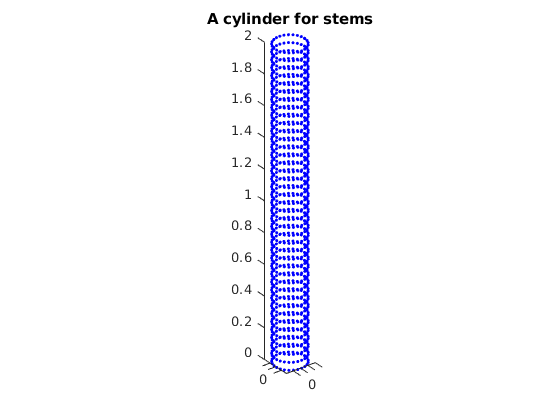

In [2]:
cylPts = [];
for h = 0:.05:2
  for th = 0:.25:2*pi
    cylPts(end+1, :) = [0.1*cos(th), 0.1*sin(th), h, 1];
  end;         
end;

clf;plot3(cylPts(:,1),cylPts(:,2),cylPts(:,3),'b.');
title('A cylinder for stems');axis equal;

Now, we define a leaf (you can change this to make it more interesting). Note that a leaf sits at the end of a stem, so we start with a cylinder!

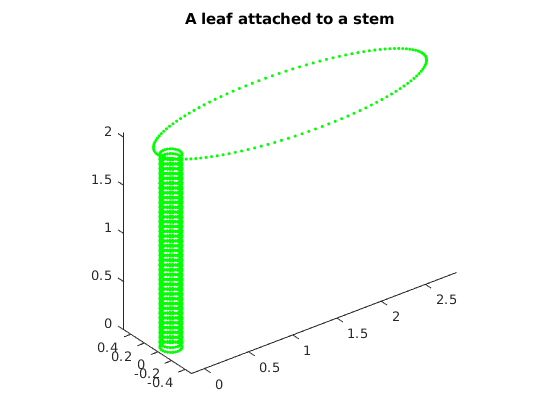

In [3]:
leafPts = cylPts;
for th = 0:.05:2*pi
   leafPts(end+1, :) = [1.35 + (1.5*cos(th)), .5*sin(th), 2.05, 1];
end;    

clf;plot3(leafPts(:,1),leafPts(:,2),leafPts(:,3),'g.');
title('A leaf attached to a stem');axis equal;

Lastly, Define a flower. Like a leaf, the flower sits at the end of a stem, so we start with a cylinder.

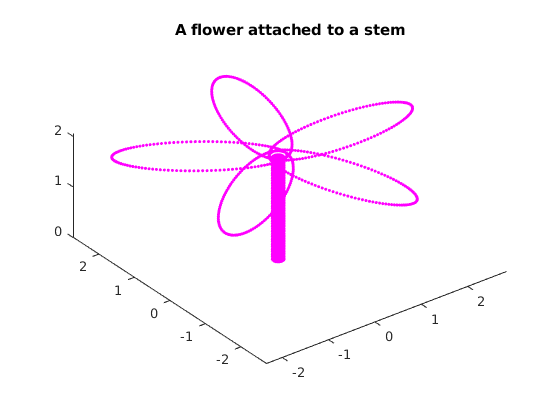

In [4]:
flowerPts = cylPts;
petal = [];
for th = 0:.05:2*pi
  petal(end+1, :) = [1.35 + (1.5*cos(th)), .5*sin(th), 2.05, 1];
end;

flowerPts = [flowerPts; petal];
pT = Rz(petal', 2*pi/5);
flowerPts = [flowerPts; pT'];
pT = Rz(petal', 4*pi/5);
flowerPts = [flowerPts; pT'];
pT = Rz(petal', 6*pi/5);
flowerPts = [flowerPts; pT'];
pT = Rz(petal', 8*pi/5);
flowerPts = [flowerPts; pT'];

clf;plot3(flowerPts(:,1),flowerPts(:,2),flowerPts(:,3),'m.');
title('A flower attached to a stem'); axis equal;

Everything's almost set up! Let's actually use our `makeLSystemTree()` function to make a tree now!

In [5]:
% No initial transform
TreeTransform = eye(4,4); 

% We can arbitrarily transform the tree by changing TreeTransform.
% Since the tree is hierarchical, the transformation propagates to
% all the objects. For example, uniform scaling by 0.9

% Get transformation matrix for scaling
[x, Ms] = Sc([1 1 1 1]', [.9 .9 .9 1]); 
                                    
% Now our tree transform has scaling!
TreeTransform = Ms * TreeTransform;     
                          
                            
% Get a tree! (Familiarize yourself with the parameters above, if you forget)
[Tree,Transforms] = makeLSystemTree(10,[.65,.15,.2,.4,.3,.3],.8,2.0,TreeTransform);

Now that we have our primitive shapes for the three symbols, let's draw the tree from the
structure and transforms we obtained from `makeLSystemTree`. You should use the symbol string you got from `makeLSystemTree`, and the corresponding transformations, to plot your tree. Finish the code to plot the tree!

*(Tip: replace `%plot native` with `%plot inline` if you're not running Jupyter locally, or just want to see the plot inline instead of in a separate window. You won't be able to pan around, however)*

Sample render:
<img src="https://imgur.com/r65WORR.png" width="300">

In [6]:
%plot native 

hold on; title('One Tree to Rule Them All!');
% view() changes the camera position for inline plots.
v = [2 1 1]; view(v); axis equal;

% TODO: Render the Tree!


---

## Exercises

---

1. Improve `makeLSystemTree()` so that any symbols "$a$" or "$b$" (stems) at the top level are capped with either a flower or a leaf (otherwise the tree looks full of bare branches at the top)

*Sample render:*
<img src="https://imgur.com/lCmpZ8z.png" width="300">

-----

2. Build a forest with multiple trees (you can use different parameters to get differently shaped trees)

*Sample render:*
<img src="https://imgur.com/VwzgfvQ.png" width="500">

***

3. Add a terrain-level - that would be a parametric surface that represents the ground - many ways to do this!

